# Fastsom on House Prices dataset

In this notebook, we'll train a Self-Organizing Map on a TabularDataBunch and use its weights as an input for a TabularModel trained on the same data.

Note: we assume data has already been downloaded. You can find the files [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import torch
import numpy as np

from fastsom import *
from fastai.tabular import *

## Importing the dataset

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Feature names
cat_names = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
    'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
    'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
    'Electrical', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
    'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'BsmtQual', 'KitchenQual']
cont_names = [
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr',
    'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch',
    'TotRmsAbvGrd', 'WoodDeckSF']
dep_var = 'SalePrice'

df_train['SalePrice'] = df_train['SalePrice'].astype(float)

## Training the SOM

In order to work with categorical data, we extended the Fast.ai Tabular API with the ability to train an unsupervised embedding model (e.g. FastText) on categorical data.
To do so, we can simply use the `SomTabularList` data block starter class with the `Vectorize` proc:

In [5]:
# We are encoding categories by generating unsupervised embeddings
procs = [FillMissing, Categorify, Vectorize, Normalize]

som_data = (SomTabularList.from_df(df_train, cat_names=cat_names, cont_names=cont_names, procs=procs)
     .split_by_rand_pct(0.2)
     .label_from_df(cols=[dep_var], label_cls=FloatList, log=True)
     .databunch(bs=64))

FillMissing 51 20
Categorify 54 20
Vectorize 54 20
Training unsupervised embeddings model...
Applying transforms...
Normalize 0 236
FillMissing 51 20
Categorify 54 20
Vectorize 54 20
Normalize 0 236


Our `SomLearner` is able to detect when the DataBunch used contains a `Vectorize` proc, and will automatically add required callbacks and change the SOM distance function into `MixedEmbeddingDistance`.

In [6]:
learn = SomLearner(som_data, size=(5,5), visualize=['weights'])

print(learn.model.dist_fn)
print(list(map(lambda cb: cb.__class__.__name__, learn.callbacks)))

MixedEmbeddingDistance
['ForwardContsCallback', 'ExperimentalSomTrainer', 'SomTrainingViz']


<IPython.core.display.Javascript object>


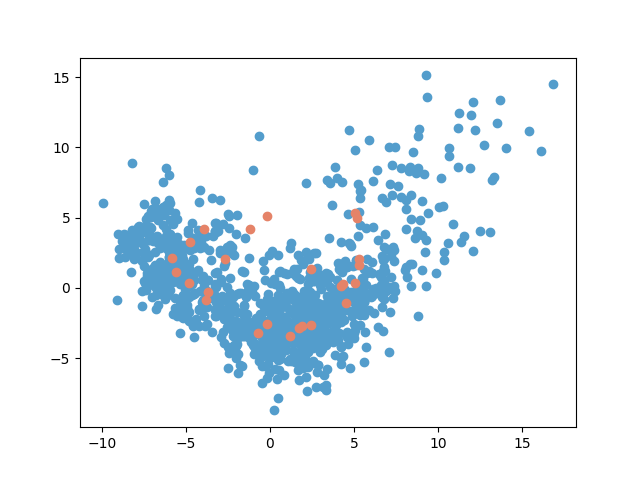

epoch,train_loss,valid_loss,time
0,14.609692,14.216131,00:01
1,14.015800,14.062551,00:00
2,13.827198,14.030153,00:00
3,13.712508,13.988311,00:00
4,13.624500,13.947805,00:00
5,13.571699,13.903400,00:00
6,13.524125,13.849051,00:00
7,13.474999,13.801827,00:00
8,13.405643,13.739798,00:00
9,13.333176,13.675531,00:00


In [7]:
%matplotlib notebook
learn.fit(20)

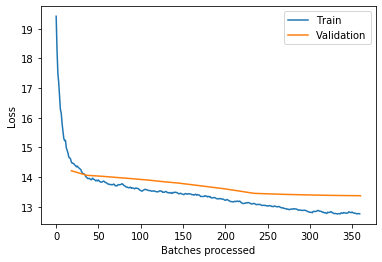

In [8]:
%matplotlib inline
learn.recorder.plot_losses()

## SOM Interpretation

The `SomInterpretation` class provides visualization utilities, to better understand the output of the training process.

In [9]:
interp = SomInterpretation.from_learner(learn)

`show_hitmap` displays a heatmap of hit counts for each map position:

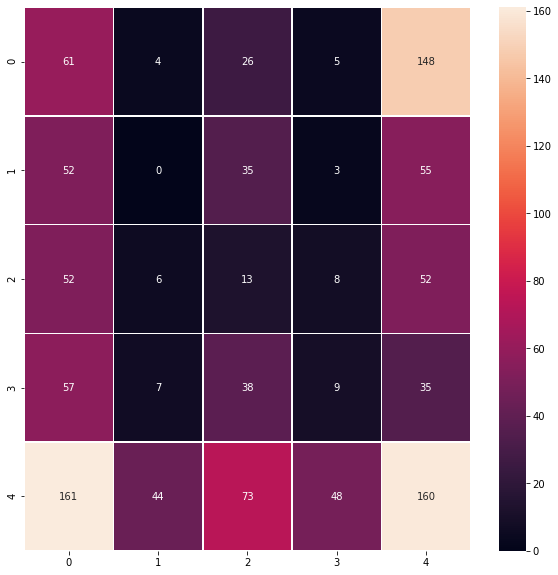

In [10]:
%matplotlib inline
interp.show_hitmap()

`show_feature_heatmaps` shows the per-feature value distribution over the SOM codebooks:

(54, 25) (25, 54)


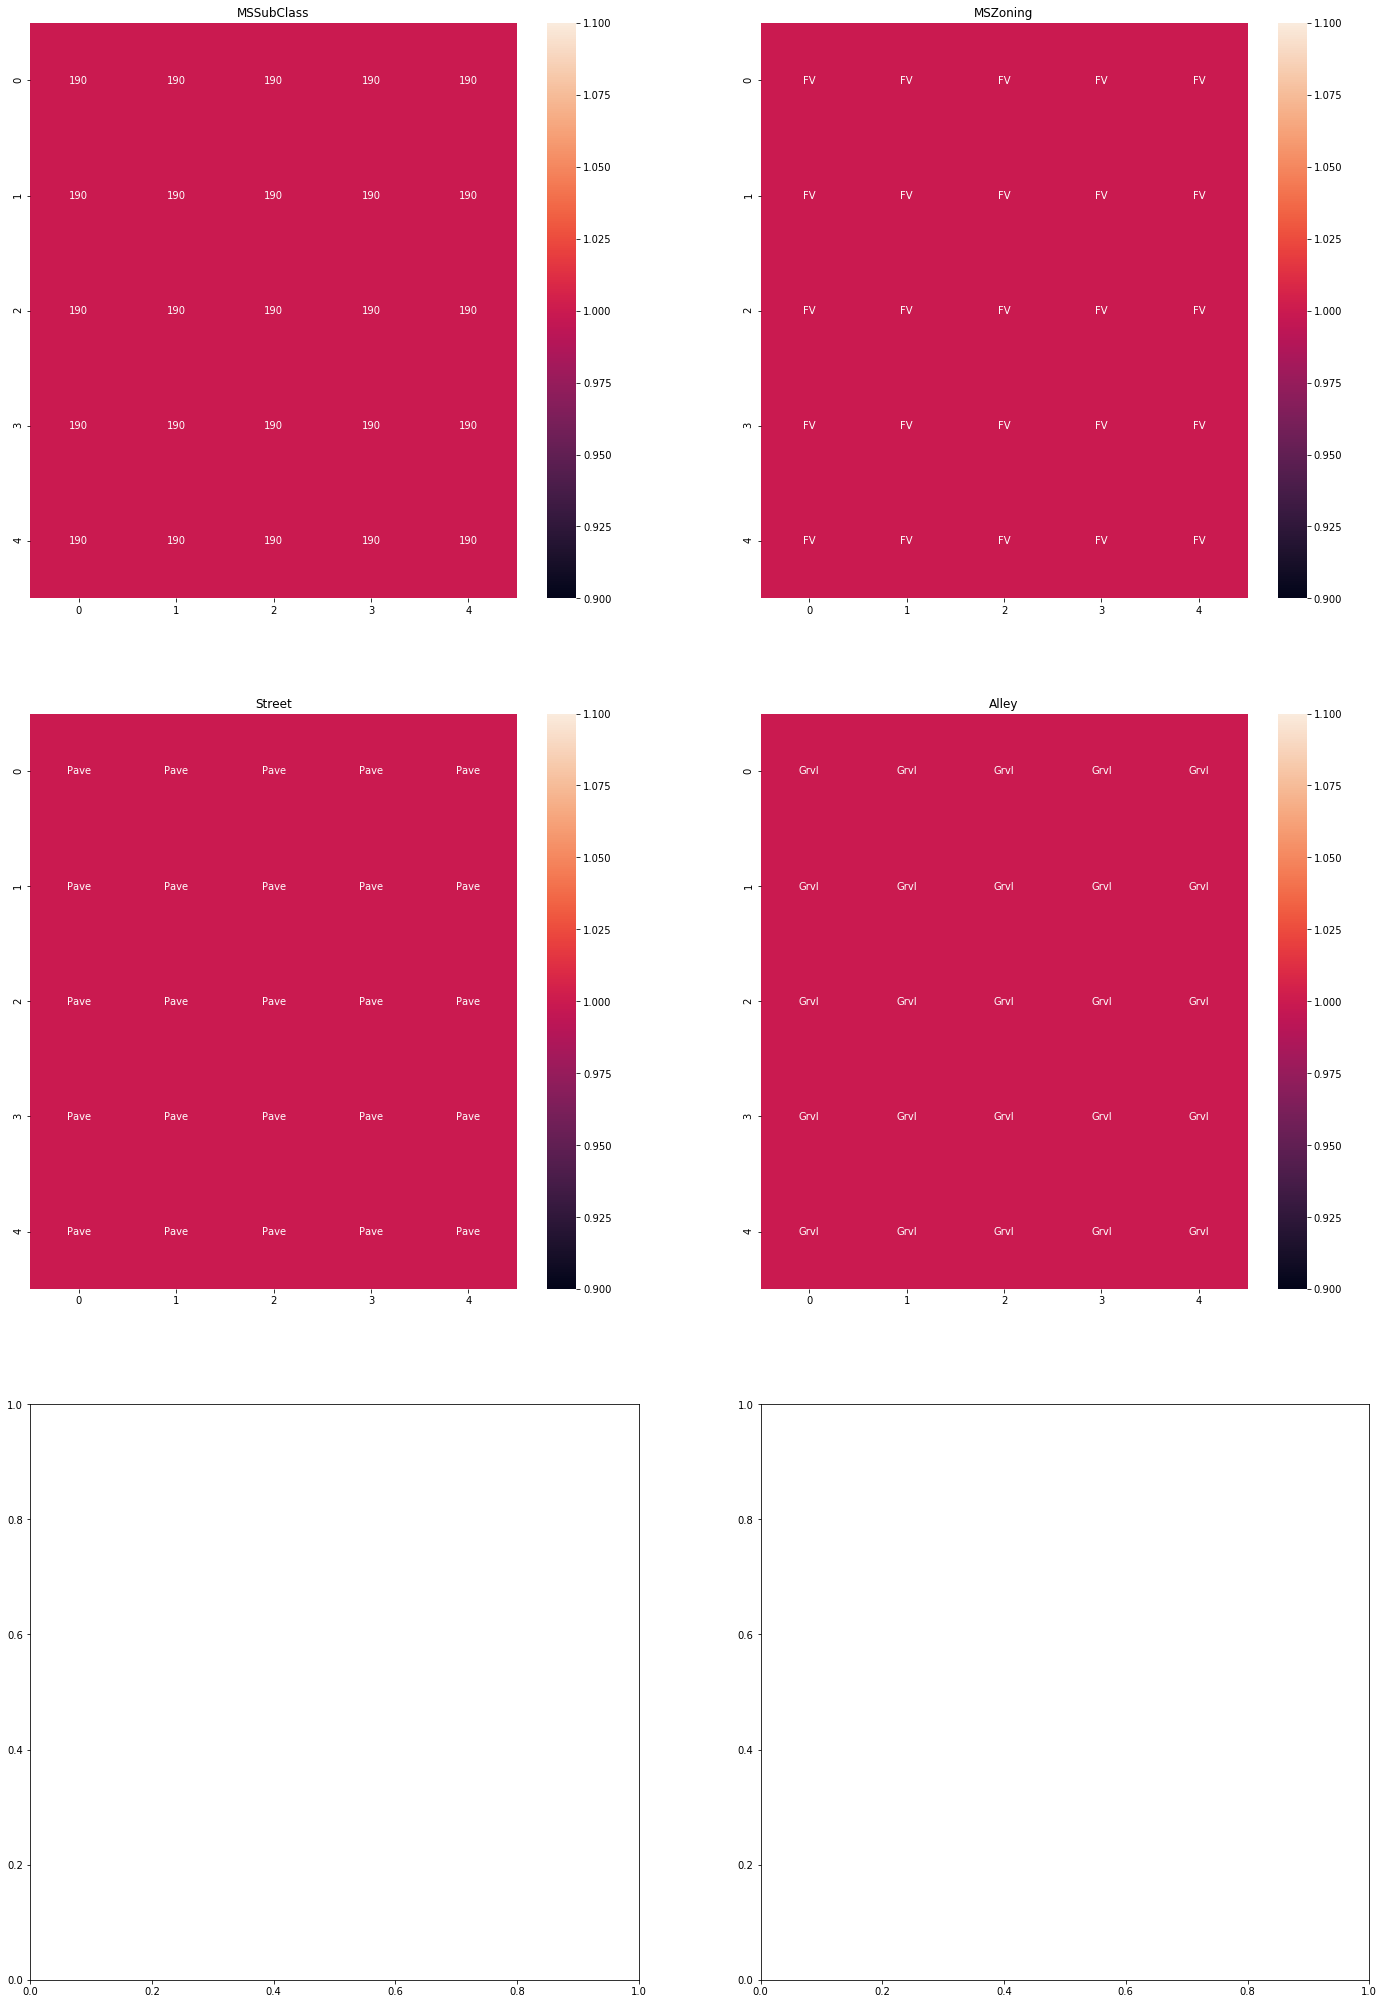

In [11]:
%matplotlib inline
interp.show_feature_heatmaps(feature_indices=[0, 1, 2, 3], recategorize=True)

`show_weights` displays a three-dimensional PCA of the SOM codebook as an RGB image:

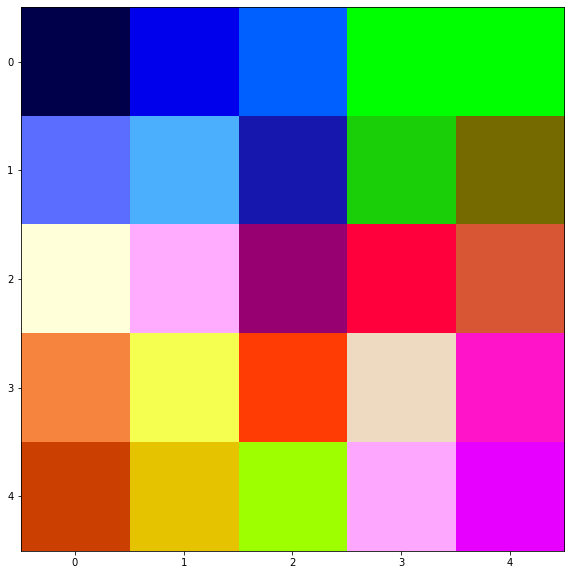

In [12]:
%matplotlib inline
interp.show_weights()

`show_preds` displays label distribution over the map, binning continuous values into `n_bins`:

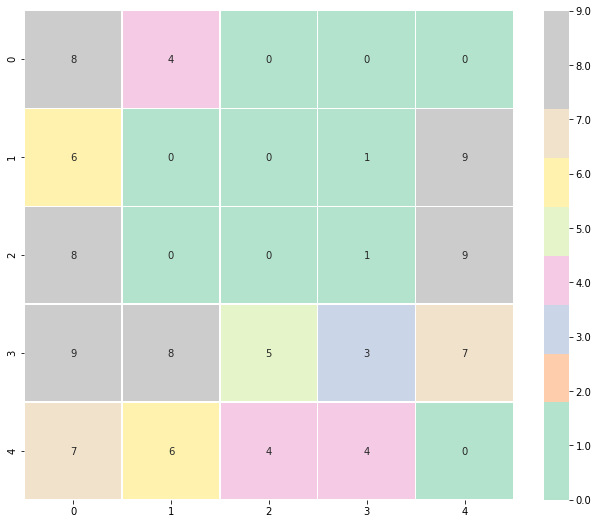

In [13]:
%matplotlib inline
interp.show_preds(n_bins=10)

## Training a Fastai Tabular model

Now that our SOM is trained, we can build a Tabular house price regressor and use it to visualize predictions over the map positions:

In [14]:
tab_procs = [FillMissing, Categorify, Normalize]
valid_pct = 0.2

# Create the tabular databunch
tabular_data = (TabularList.from_df(df_train, path='.', cat_names=cat_names, cont_names=cont_names, procs=tab_procs)
            .split_by_rand_pct(valid_pct)
            .label_from_df(cols=[dep_var], label_cls=FloatList, log=True)
            .databunch())

# create a logarithmic target to scale sale prices
max_log_y = np.log(np.max(df_train[dep_var])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

learn_tab = tabular_learner(tabular_data, layers=[1000,500], y_range=y_range, metrics=exp_rmspe)

learn_tab.fit_one_cycle(4, max_lr=(2e-2))

epoch,train_loss,valid_loss,exp_rmspe,time
0,20.627666,10.598777,1.556972,00:01
1,13.517563,0.282299,0.749958,00:01
2,8.980394,2.879755,0.545477,00:01
3,6.930640,2.839306,0.505786,00:01


The `SomLearner.codebook_to_df` method is useful to export the codebook values as a test dataset.

In [15]:
import matplotlib.pyplot as plt
# Create test dataset from SOM codebook
df_som = learn.codebook_to_df(recategorize=True)
df_som

(54, 25) (25, 54)


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,LotFrontage,LowQualFinSF,MasVnrArea,OpenPorchSF,PoolArea,ScreenPorch,TotRmsAbvGrd,WoodDeckSF,som_row,som_col
0,80,C (all),Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,55.094230,3.578885,99.131454,71.289630,0.403184,4.318260,5.833193,69.796070,0,0
1,80,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,...,57.863777,8.911884,82.891396,52.061832,0.427913,5.027372,6.041433,66.069840,0,1
2,85,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,63.527214,13.385137,48.291270,30.419294,0.632407,4.415264,6.457751,41.782840,0,2
3,85,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,60.585094,14.625126,40.838120,26.493494,0.186492,10.752041,6.330411,50.299988,0,3
4,30,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,...,59.785225,15.219814,56.276080,24.588886,0.017034,14.592091,6.334594,57.681170,0,4
5,80,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,...,61.948610,1.528332,171.376560,61.729523,4.051273,13.522209,6.329365,118.564514,1,0
6,85,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,...,65.045140,8.331241,134.051530,57.474995,4.103004,9.269087,6.441457,90.496800,1,1
7,85,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,64.609535,22.198603,47.491417,41.369667,3.279768,8.066299,6.218157,55.358864,1,2
8,85,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,62.642410,17.854370,38.942352,29.038656,0.603029,12.882672,6.279758,56.030514,1,3
9,30,RL,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,...,61.941437,13.613878,34.903650,27.786474,0.504108,15.480295,6.351683,59.325115,1,4


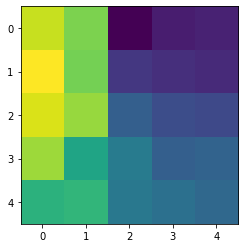

In [16]:
%matplotlib inline
tabular_data.add_test(TabularList.from_df(df_som))

# Run tabular model predictions
preds, _ = learn_tab.get_preds(DatasetType.Test)

# Display output
plt.imshow(preds.view(*(learn.model.size[:-1])))